In [1]:
import pandas as pd
import sklearn.metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

# face_path = 'stats/vid-face-preds-211022-1639.csv'
# face_path = 'stats/vid-face-preds-211022-1713.csv'
face_path = 'stats/vid-face-preds-211106-0909.csv'
df = pd.read_csv(face_path)

In [2]:
face_filenames = df['filename'].to_numpy()
df

,filename,label,audio_fake,face_fake,swap_fake,both_fake,median,1st_quartile_pred,3rd_quartile_pred,group_pred
0,9a22372d22a52397.mp4,1,1.0,1.0,0,1,0.999568,0.995638,0.999927,0.999686
1,9bc4f1306bb8e2cd.mp4,1,1.0,1.0,0,1,0.997323,0.962807,0.999860,0.998493
2,88fe2a902a9d8cc7.mp4,1,1.0,1.0,0,1,0.999326,0.997067,0.999958,0.999703
3,1f3cbda142d0944a.mp4,1,1.0,1.0,0,1,0.998871,0.997290,0.999831,0.999158
4,63bed62257daccaf.mp4,1,1.0,1.0,0,1,0.997788,0.975152,0.999854,0.999870
...,...,...,...,...,...,...,...,...,...,...
6938,f5c4bfb20068f129.mp4,0,0.0,0.0,0,0,0.237312,0.027877,0.389423,0.351240
6939,b7b7b7f6db7f6e2e.mp4,0,0.0,0.0,0,0,0.040162,0.008745,0.163303,0.135718
6940,c3fc75289ae3b41e.mp4,0,0.0,0.0,0,0,0.507716,0.392383,0.627312,0.589261
6941,519e97d4c90aaa1c.mp4,0,0.0,0.0,0,0,0.005328,0.000529,0.023253,0.009802


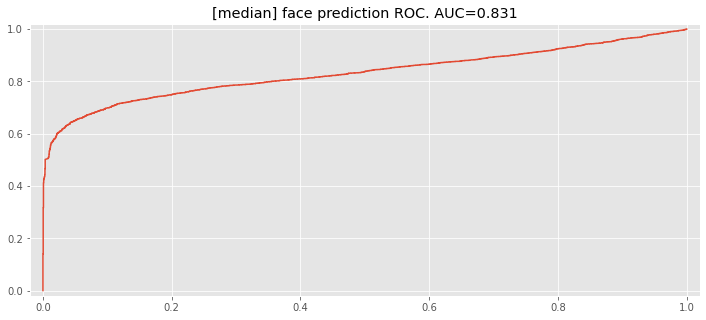

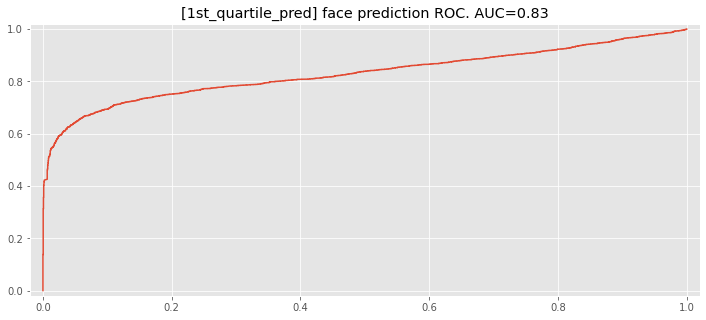

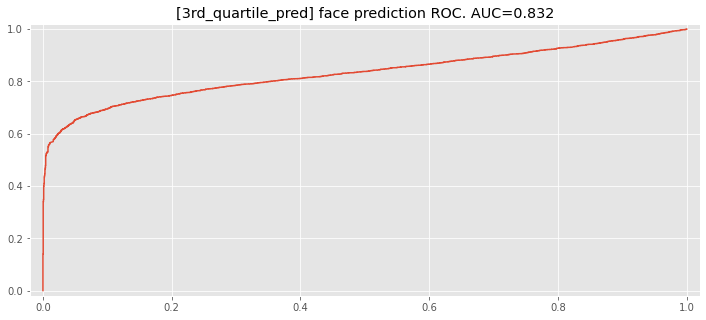

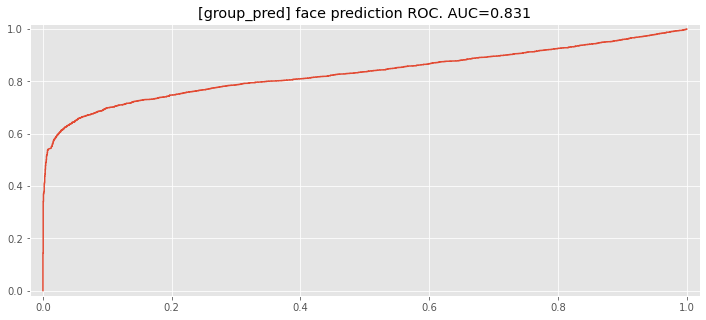

In [3]:
sub_df = df[
    (df['face_fake'] == 1) | (df['label'] == 0)
]

for metric in ['median', '1st_quartile_pred', '3rd_quartile_pred', 'group_pred']:
    labels = df['label'].to_numpy()
    face_preds = df[metric].to_numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, face_preds)
    auc = sklearn.metrics.roc_auc_score(labels, face_preds)

    plt.style.use('ggplot')
    plt.figure(figsize=(12, 5))
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.title(f"[{metric}] face prediction ROC. AUC="+str(round(auc, 3)))
    plt.plot(fpr, tpr)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


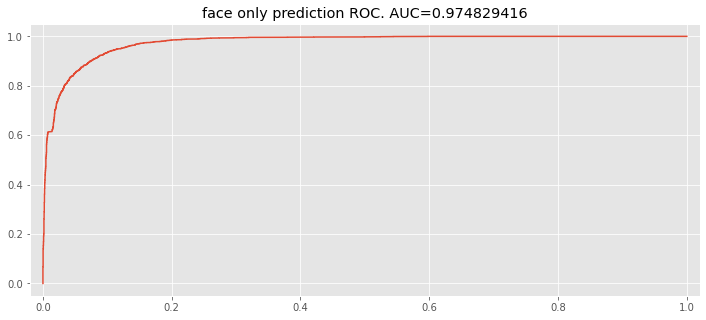

In [13]:
print(df['label'].to_numpy())
face_labels = df['face_fake'].to_numpy(dtype=int)
print(face_labels)

face_preds = df['1st_quartile_pred'].to_numpy()
# face_preds = df['3rd_quartile_pred'].to_numpy()

fpr, tpr, _ = sklearn.metrics.roc_curve(face_labels, face_preds)
auc = sklearn.metrics.roc_auc_score(face_labels, face_preds)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("face only prediction ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)

In [14]:
audio_path = 'FakeVoiceTorch/csvs/aisg-preds-211013-1810.csv'
audio_df = pd.read_csv(audio_path)
assert (audio_df['filename'] == face_filenames).all()
audio_preds = audio_df['median_pred'].to_numpy()
print(audio_preds)

[9.42155659e-01 9.54890847e-01 9.53007996e-01 ... 1.60283148e-02
 6.90651178e-01 9.43817955e-04]


In [66]:
mixed_preds = np.max([audio_preds, face_preds], axis=0)
mixed_preds += audio_preds * face_preds * 0.02
print(mixed_preds)

[1.01439936e+00 9.81194269e-01 1.01607166e+00 ... 3.92508615e-01
 6.90658481e-01 9.43827967e-04]


[1 1 1 ... 0 0 0]
[1.01439936e+00 9.81194269e-01 1.01607166e+00 ... 3.92508615e-01
 6.90658481e-01 9.43827967e-04]


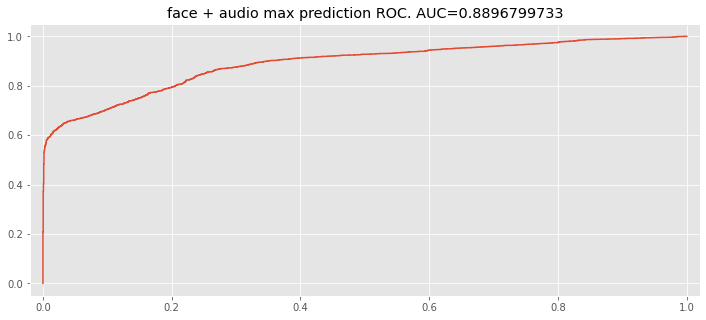

In [67]:
print(df['label'].to_numpy())
print(mixed_preds)
labels = df['label'].to_numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(labels, mixed_preds)
auc = sklearn.metrics.roc_auc_score(labels, mixed_preds)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("face + audio max prediction ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)

In [17]:
squish_preds = []
for k in range(len(face_preds)):
    f_pred = face_preds[k]
    a_pred = audio_preds[k]
    
    if (f_pred > 0.5) and (a_pred > 0.5):
        squish_preds.append(1 - (1-f_pred)*(1-a_pred))
    else: 
        squish_preds.append(max(a_pred, f_pred))

[1 1 1 ... 0 0 0]


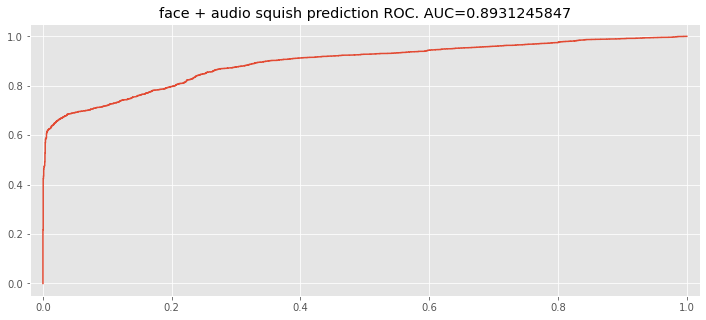

In [20]:
print(df['label'].to_numpy())
# print(squish_preds)
labels = df['label'].to_numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(labels, squish_preds)
auc = sklearn.metrics.roc_auc_score(labels, squish_preds)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("face + audio squish prediction ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)

In [21]:
swap_fakes = df['swap_fake'].to_numpy() * 1
op_preds = np.max([swap_fakes, squish_preds], axis=0)
print(sum(swap_fakes) / len(df))

0.1035575399683134


In [22]:
print(op_preds)

[9.99747708e-01 9.98322245e-01 9.99862191e-01 ... 3.92382830e-01
 6.90651178e-01 9.43817955e-04]


[1 1 1 ... 0 0 0]


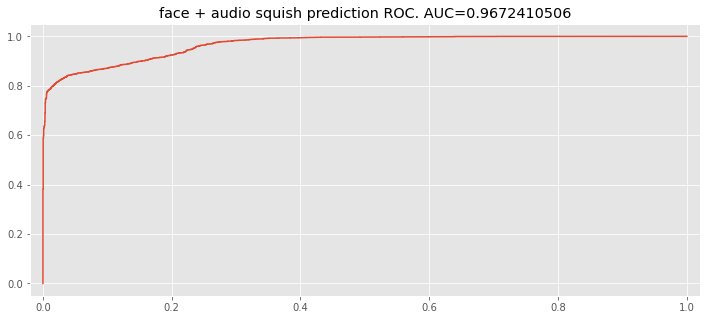

In [23]:
print(df['label'].to_numpy())
# print(squish_preds)
labels = df['label'].to_numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(labels, op_preds)
auc = sklearn.metrics.roc_auc_score(labels, op_preds)

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05])
plt.title("face + audio squish prediction ROC. AUC="+str(round(auc, 10)))
plt.plot(fpr, tpr)